# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric import seed_everything

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model

seed = 4
seed_everything(seed)

data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [2]:
walk_results = pd.read_csv(reports_folder+"random_walks/random_walk_results.csv",index_col=0)
seeds = [4,5,6,7,8]
data = []
for seed in seeds:
    datasets, node_map = training_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")

In [3]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] not in ["lsa","lsa_norm","lsa_scaled"]:
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)

    # Initialize model
    model = base_model.base_model(
        params, train_set.metadata(), params["supervision_types"]
    )
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

In [11]:
best_params = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[0].to_dict()
best_experiment_id = walk_results.sort_values(by="mean_auc",ascending=False).drop(columns=["mean_auc","std"]).iloc[0].name
best_params["layer_connectivity"] = None
best_params["supervision_types"] = [("gene_protein","gda","disease")]
scaled_params = best_params|{"feature_type":"lsa_scaled"}
norm_params = best_params|{"feature_type":"lsa_norm"}

In [28]:
negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}
for name, param_set in zip(["scaled", "normalized"],[scaled_params,norm_params]):
    metrics,models,curves = run_multiple_seeds(data,param_set,negative_sampler)
    results[name] = [metrics,models,curves]
    print(metrics)

/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packag

(0.859, 0.0030983866769659363)


/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/ingrid/Documents/tesis/gcnn_gdas/venv/lib/python3.10/site-packag

(0.86, 0.0014142135623730963)


In [56]:
experiment_results = pd.DataFrame({"preprocess":["scaled","normalized"],"mean_auc":[results["scaled"][0][0],results["normalized"][0][0]], "std":[results["scaled"][0][1],results["normalized"][0][1]],"curve_data":[results["scaled"][2],results["normalized"][2]]})

In [59]:
experiment_results.to_parquet(reports_folder+"scaling_tests/scaling_experiment.parquet")

In [23]:
walk_results.sort_values(by="mean_auc",ascending=False).iloc[0][["mean_auc","std"]]

mean_auc    0.8652
std         0.0036
Name: 41, dtype: object

In [60]:
experiment_results

,preprocess,mean_auc,std,curve_data
0,scaled,0.859,0.003098,"[[[0.8949589133262634, 0.8407887816429138, 0.7..."
1,normalized,0.860,0.001414,"[[[0.8817894458770752, 0.81870037317276, 0.779..."


In [13]:
experiment_results = pd.read_parquet(reports_folder+"scaling_tests/scaling_experiment.parquet")
random_walk_curves = np.load(reports_folder+f"random_walks/step_{best_experiment_id}_curve.npy",allow_pickle=True)

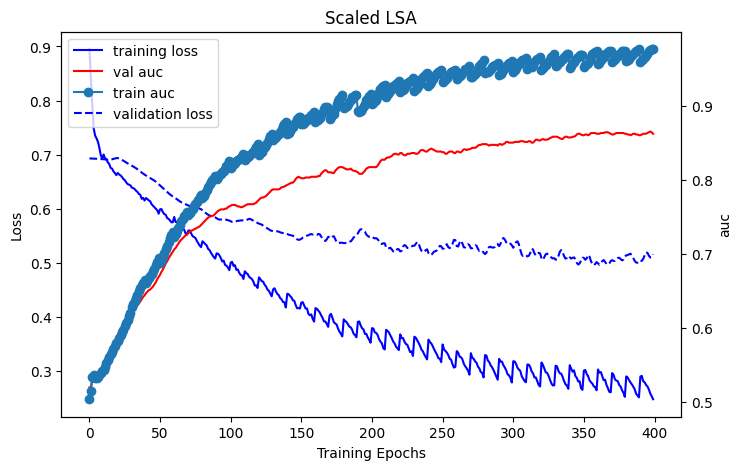

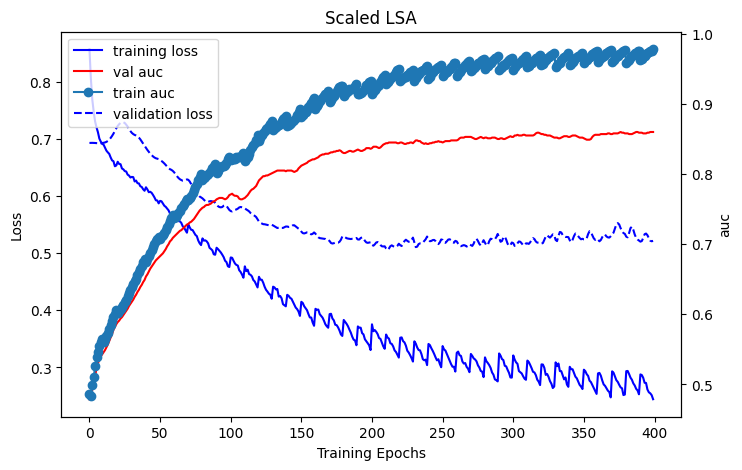

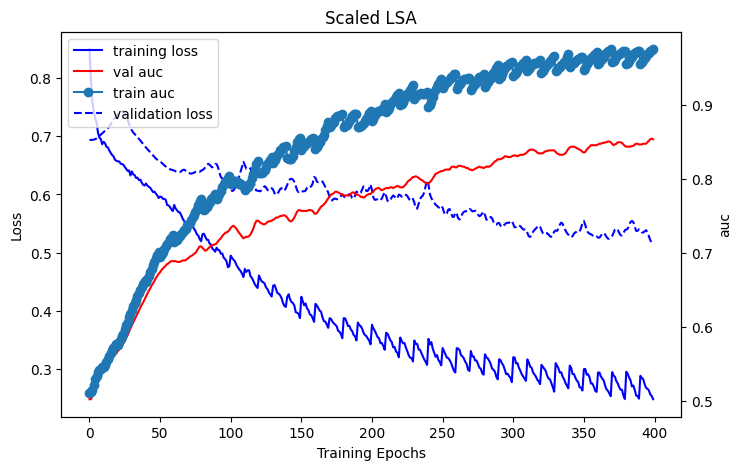

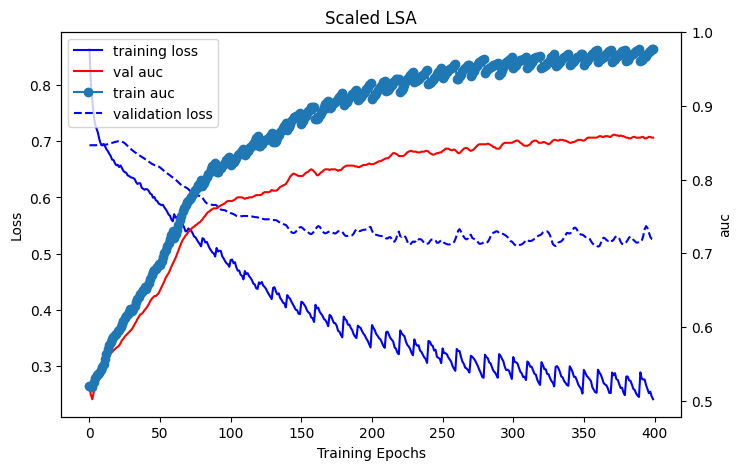

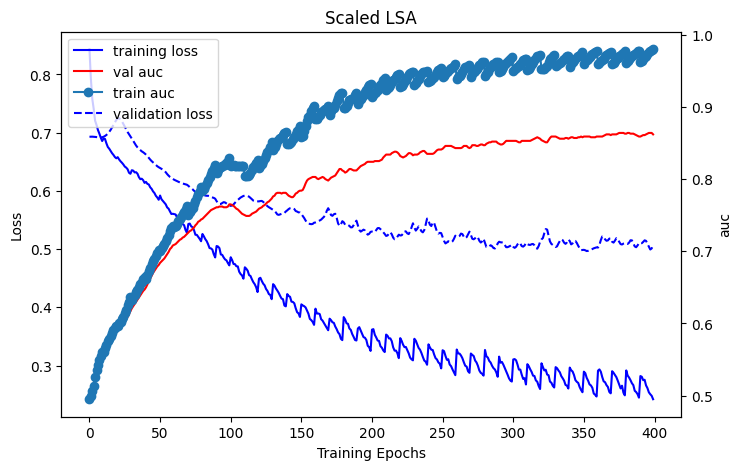

In [17]:
for split in range(5):
    curves = experiment_results.loc[0,"curve_data"][split]
    training_utils.plot_training_stats("Scaled LSA",*curves,"auc")

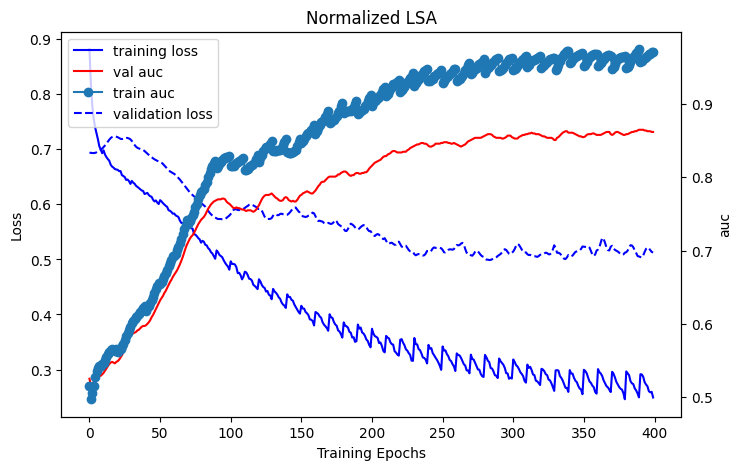

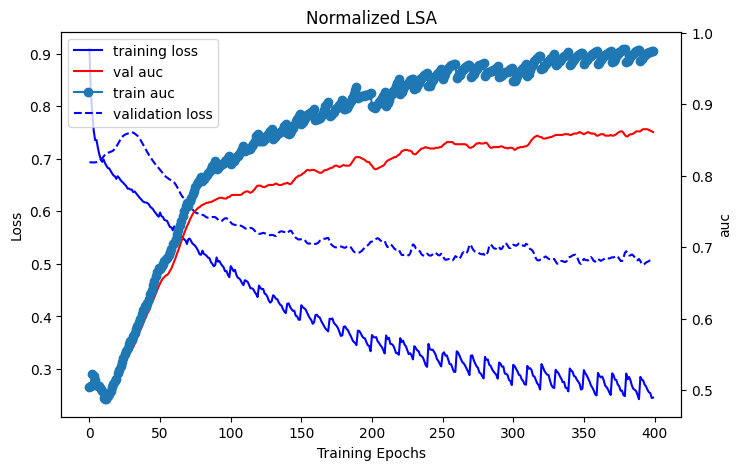

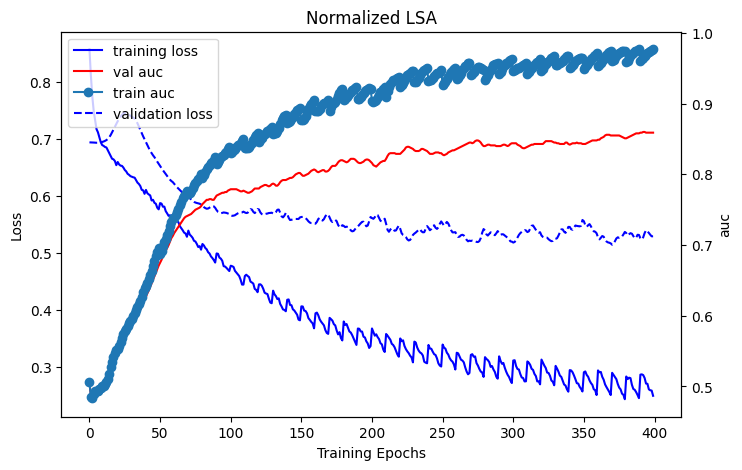

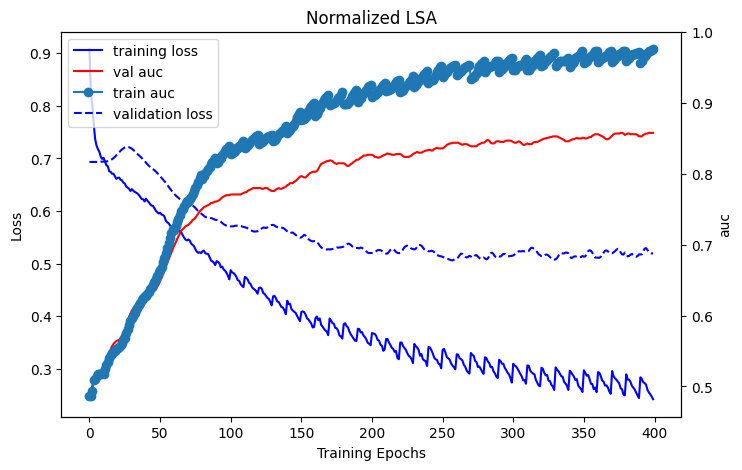

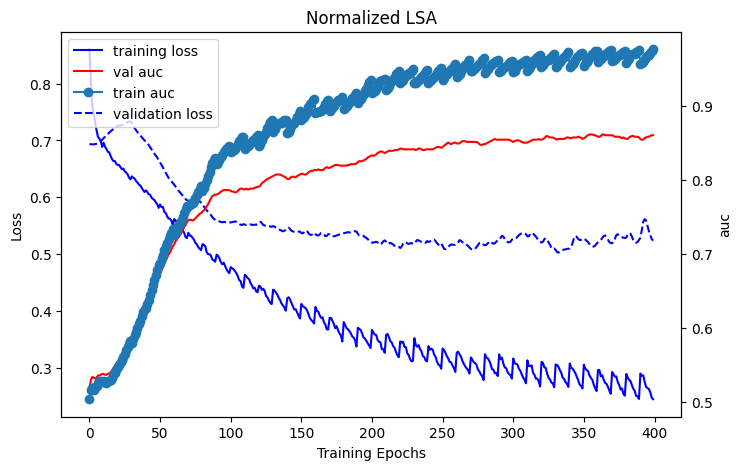

In [18]:
for split in range(5):
    curves = experiment_results.loc[1,"curve_data"][split]
    training_utils.plot_training_stats("Normalized LSA",*curves,"auc")

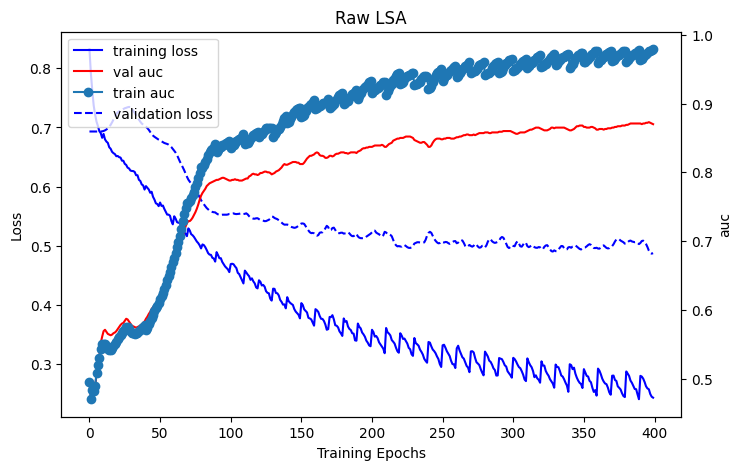

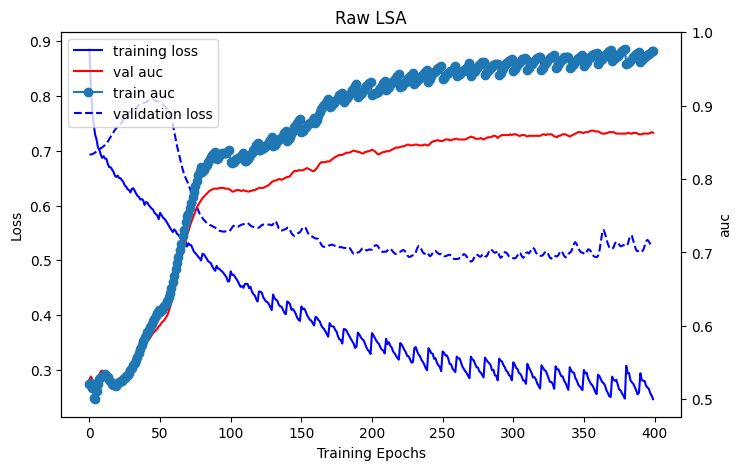

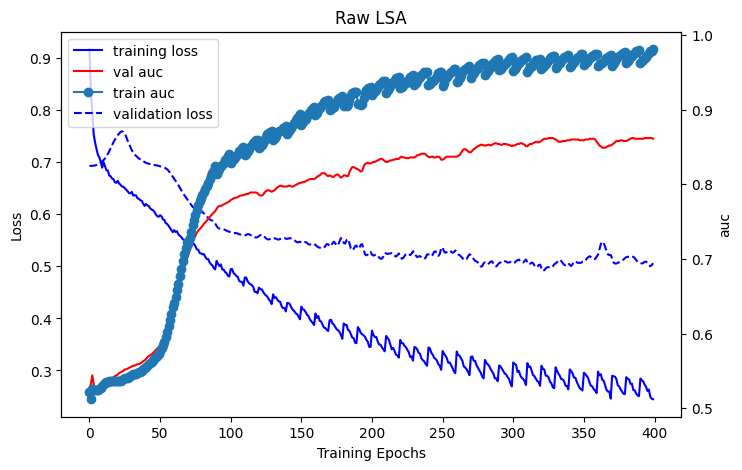

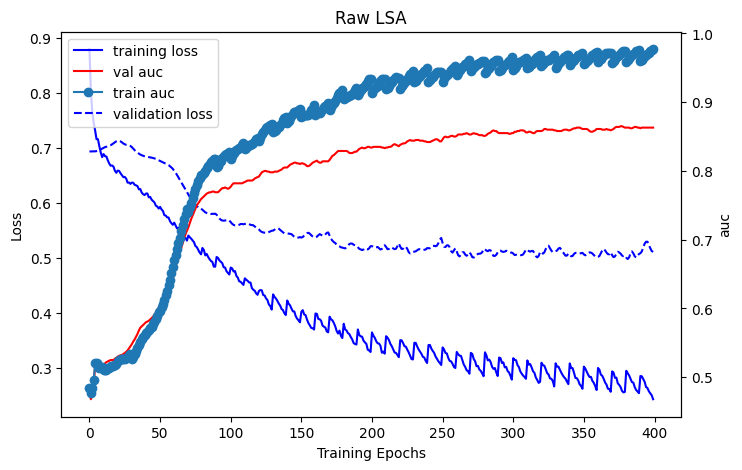

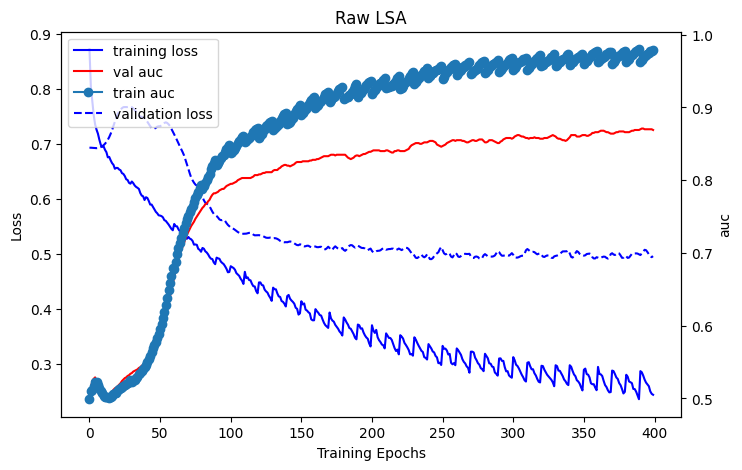

In [20]:
for split in range(5):
    curves = random_walk_curves[split]
    training_utils.plot_training_stats("Raw LSA",*curves,"auc")